In [2]:
from __future__ import division
import numpy as np
from scipy import io
import skimage
from skimage import feature
from scipy import linalg as la
from matplotlib import pyplot as plt
import matplotlib
import seaborn
%matplotlib inline

def notes():
    """
    Implement the Kalman filter algorithm on two datasets. Produce two
    visualizations of the observations, the true state, the estimated state,
    and the estimate of the variance of the state estimates.

    For the first data set (kfdata):
        - Implement a simple random accelerations model and use it to track a
          simple target.

    For the second dataset (ball_data):
        - Use a series of (x,y) observations from a visual processing task
        - Set the parameters of the filter to the best values you can, and 
          show a visualization of the result.
              1. A series of frame snapshots showing the estimated position and
                 uncertainty.
              2. A plot of how the ball moved around in the field of view.


    Outline of Kalman Filter
    ------------------------
    
    mu_t = A*mu_t-1 + K_t(y_t - yhat_t)
    sig_t = (eye - K_t*C)*sigprime_t-1
    
    yhat_t = C*A*mu_t-1
    sigprime_t-1 = A*sig_t*A.T + Q
    K_t = sigprime_t-1*C.T*S_t_inv
    S_t = C*sig_t-1*C.T + R
    
    Notice that A, C, Q and R are fixed.
    yt is the actual data
    
    To update:
        1. sigprime_t-1 = A*sigprime_t*A.T + Q
        2. S_t = C*sigprime_t-1*C.t + R
        3. K_t = sigprime_t-1*C.T*inv(S_t)
        4. yhat_t = C*A*mu_t-1
        5. sig_t = (np.eye(?) - Kt*C)*sigprime_t-1
        5. mu_t = A*mu_t-1 + Kt*(yt - yhat_t) (yt = data[i,:])
    """

(2L, 6L)


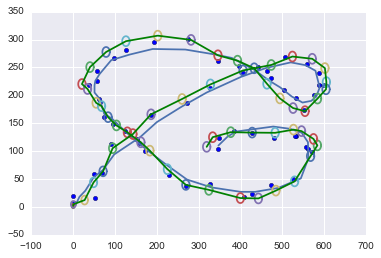

In [3]:
kfdata = io.loadmat('kfdata.mat')

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
print C.shape
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
 
# initial state
mu = np.zeros(( 6, 1 ))
sig = np.eye( 6 ) # covariance

# Helper code for plotting 95% confidence interval
def cov_to_pts(cov):
    circ = np.linspace(0, 2*np.pi, 100)
    sf = np.array([np.cos(circ), np.sin(circ)])
    
    U, S, V = la.svd(cov)
    pmat = U*2.447*np.sqrt(S) # 95% confidence
    return np.dot(pmat, sf)

data = kfdata['data']
true_data = kfdata['true_data']
plt.plot(true_data[:,0], true_data[:,1])
plt.scatter(data[:,0],data[:,1])

circ = cov_to_pts(sig[:2,:2])
plt.plot(circ[0,:],circ[1,:])

pts = np.zeros((56,2))

for t in xrange(56):
    sigprime = np.dot(A,np.dot(sig,A.T)) + Q
    S = np.dot(C,np.dot(sigprime,C.T)) + R
    K = np.dot(np.dot(sigprime,C.T),la.pinv(S))
    yhat = np.dot(C,np.dot(A,mu))
    sig = np.dot(np.eye(6) - np.dot(K,C),sigprime)
    mu = np.dot(A,mu) + np.dot(K,data[t,:].reshape((2,1)) - yhat)
    
    circ = cov_to_pts(sig[:2,:2])
    pts[t,:] = mu[:2].reshape(2)
    plt.plot(circ[0,:] + mu[0],circ[1,:] + mu[1])
    """
    A is 6x6
    C is 2x6
    Q is 6x5
    mu is 6x1
    sig is 6x6
    sigprime is 6x6
    R is 2x2
    S is (2x6)x(6x6)x(6x2) + (2x2) = 2x2
    K is (6x6)x(6x2)x(2x2) = 6x2
    yhat is (2x6)x(6x6)x(6x1) = (2x1)
    
    
    To update:
        1. sigprime_t-1 = A*sig_t*A.T + Q
        2. S_t = C*sigprime_t-1*C.t + R
        3. K_t = sigprime_t-1*C.T*inv(S_t)
        4. yhat_t = C*A*mu_t-1
        5. sig_t = (np.eye(?) - Kt*C)*sigprime_t-1
        5. mu_t = A*mu_t-1 + Kt*(yt - yhat_t) (yt = data[i,:])
    """

fig_size = plt.rcParams["figure.figsize"] 
fig_size = 8,6
plt.rcParams["figure.figsize"] = fig_size 
plt.plot(pts[:,0],pts[:,1],color='green')
plt.show()

(160L, 2L)
(2L, 6L)


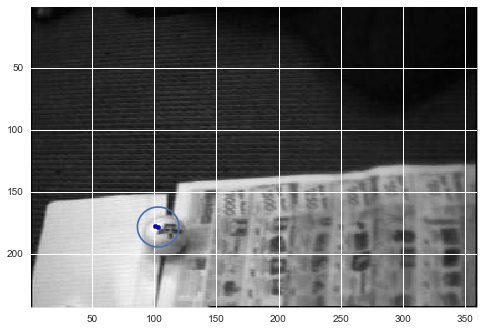

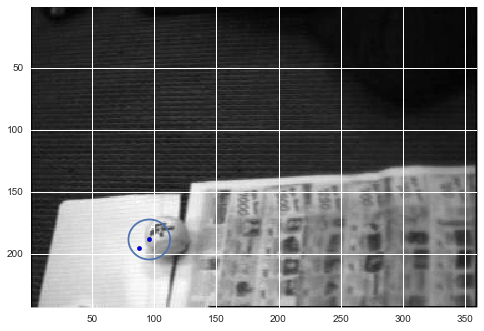

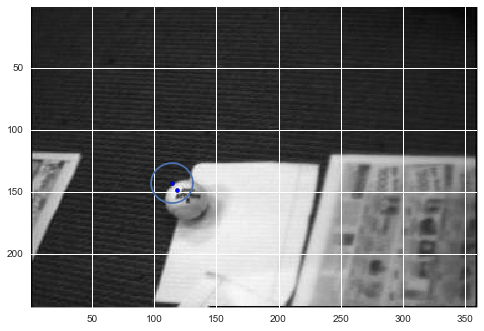

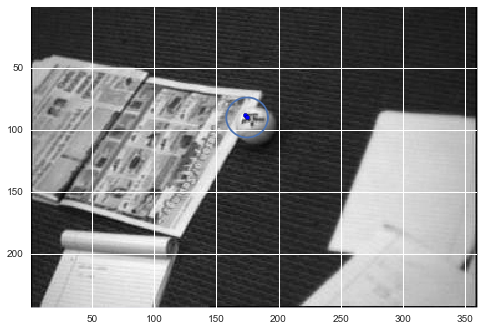

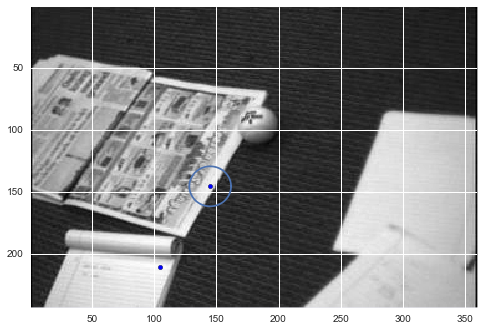

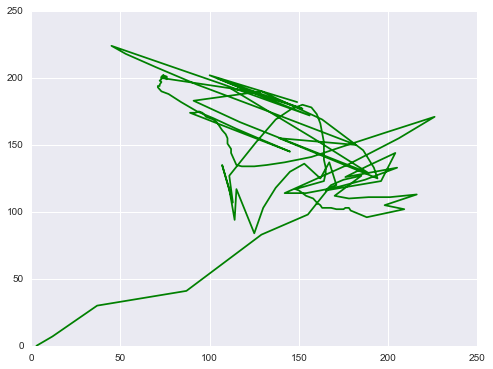

In [13]:
tmp = io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template
 
data = []
for i in range( 0, frames.shape[1] ):
    # slurp out a frame
    tmp = np.reshape( frames[:,i], (360,243) ).T  
    
    # create a normalized cross correlation image
    ncc = skimage.feature.match_template( tmp, ball ) 
    
    # find the point of highest correlation
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  
    
    data.append( maxloc )  # record the results
    
data = np.asarray( data )
print data.shape

# Set up A, C, R, Q (initially using same as before)

# our dynamics are described by random accelerations
# what about velocity?
# I tried making it upper triangular but it made everything way worse
A = np.diag(np.ones(6)) + np.diag(np.ones(4),2) + np.diag(0.1*np.ones(2),4)

# Nothing I did seemed to affect the model too much.
 
# our observations are only the position components
# this doesn't need to be tweaked
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
print C.shape
 
# I'm assuming the random accelerations are a result of the other objects in
# the scene. I want them to mostly have a fairly similar variance.
# This didn't make my plot look any more like yours
#Q = 1e-2 * np.eye( 6 )
Q = np.diag(np.array([.01,.01,.01,.01,.1,.05]))

 
# our observation noise
# I tried fiddling with the noise parameter and it did not seem to affect the
# outcome much, but it made the tracking plot a little smoother so I kept it
R = 100 * np.eye( 2 )


mu = np.zeros((6,1))
sig = np.eye(6)
pts = np.zeros_like(data)

for t in xrange(data.shape[0]):
    
    sigprime = np.dot(A,np.dot(sig,A.T)) + Q
    S = np.dot(C,np.dot(sigprime,C.T)) + R
    K = np.dot(np.dot(sigprime,C.T),la.pinv(S))
    yhat = np.dot(C,np.dot(A,mu))
    sig = np.dot(np.eye(6) - np.dot(K,C),sigprime)
    mu = np.dot(A,mu) + np.dot(K,data[t,:].reshape((2,1)) - yhat)
    
    circ = cov_to_pts(sig[:2,:2])
    pts[t,:] = mu[:2].reshape(2)
    
    if t in [54,56,78,106,107]:
        tmp = np.reshape( frames[:,t], (360,243) ).T
 
        plt.figure(1)
        plt.clf()
        plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
        plt.scatter( data[t][1], data[t][0] )
        plt.scatter( mu[1], mu[0] )

        foo = cov_to_pts( sig[0:2,0:2] )

        plt.plot( foo[0,:] + mu[1], foo[1,:] + mu[0] )
        plt.xlim([1, 360])
        plt.ylim([243,1])
        plt.show()
    
fig_size = plt.rcParams["figure.figsize"] 
fig_size = 8,6
plt.rcParams["figure.figsize"] = fig_size 
plt.plot(pts[:,0],pts[:,1],color='green')
plt.show()